---
title: 6.4 含并行连结的网络（GoogLeNet）
date: 2024-4-22 13:00:00
tags: [机器学习,pytorch]
categories: [机器学习]
comment: true
toc: true
---
#
<!--more-->
# 4 含并行连结的网络（GoogLeNet）
- GoogLeNet吸收了NiN中串联网络的思想，解决了什么样大小的卷积核最合适的问题。有时使用不同大小的卷积核组合是有利的。
## 4.1 Inception块
- 在GoogLeNet中，基本的卷积块被称为Inception块（Inception block）。这很可能得名于电影《盗梦空间》（Inception），因为电影中的一句话“我们需要走得更深”（“We need to go deeper”）。
![](../../../../../../themes/yilia/source/img/deeplearning/code/pytorch/6_moden_conv/4_googlenet/1.png)
![](img/deeplearning/code/pytorch/6_moden_conv/4_googlenet/1.png)
- Inception块由四条并行路径组成。前三条路径使用窗口大小为1 × 1、3 × 3和5 × 5的卷积层，从不同空间大小中提取信息。

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs) -> None:
        super(Inception, self).__init__(**kwargs)
        # 线路1， 单1 x 1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2， 1 x 1卷积层后接3 x 3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3， 1 x 1卷积层后接5 x 5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4， 3 x 3最大池化层后接1 x 1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
    def forward(self, X):
        p1 = F.relu(self.p1_1(X))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(X))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(X))))
        p4 = F.relu(self.p4_2(self.p4_1(X)))
        # 在通道维度上连接输出
        return torch.cat((p1, p2, p3, p4), dim=1)

- GoogLeNet可以用各种滤波器尺寸探索图像，这意味着不同大小的滤波器可以有效地识别不同范围的图像细节。
## 4.2 GoogLeNet模型
- GoogLeNet使用9个Inception块和全局平均汇聚层的堆叠来生成其估计值。Inception块之间的最大汇聚层可降低维度。
- 第一个模块类似于AlexNet和LeNet，Inception块的组合从VGG继承，全局平均汇聚层避免了在最后使用全连接层。
- GoogLeNet架构：

![](../../../../../../themes/yilia/source/img/deeplearning/code/pytorch/6_moden_conv/4_googlenet/2.png)
![](img/deeplearning/code/pytorch/6_moden_conv/4_googlenet/2.png)

In [2]:
# 1. 第一个模块使用64个通道、7 × 7卷积层。
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)
# 2. 第二个模块使用两个卷积层：64个通道1 × 1卷积层、通道数量增加三倍的3 × 3卷积层
b2 = nn.Sequential(
    nn.Conv2d(64,64,kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)
# 3. 第三个模块串联两个完整的Inception块。
# Inception_1的输出通道为64+128+32+32=256，第2和第3路径将输入通道数量分别减少到96/192 = 1/2和16/192 = 1/12，然后连接第二个卷积层。
# Inception_2的输出通道为128+192+96+64=480，第二条和第三条路径首先将输入通道的数量分别减少到128/256 = 1/2和32/256 = 1/8
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)
# 4. 第四个模块串联五个Inception块
b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)
# 5. 第五个模块串联两个Inception块
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten()
)

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

- 查看形状

In [3]:
X = torch.rand(size=(1,1,96,96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


## 4.3 训练模型
- 训练之前，我们将图片转换为96x96大小，然后进行训练。

KeyboardInterrupt: 

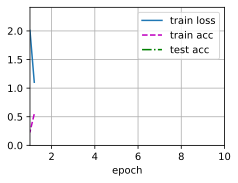

In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())